In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



class LSTM_Node(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_Node, self).__init__()
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, h, c):
        x_h = torch.cat((x, h), 1)
        f = torch.sigmoid(self.forget_gate(x_h))
        i = torch.sigmoid(self.input_gate(x_h))
        c_tilde = torch.tanh(self.cell_gate(x_h))
        c_new = f * c + i * c_tilde
        o = torch.sigmoid(self.output_gate(x_h))
        h_new = o * torch.tanh(c_new)
        return h_new, c_new
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nodes = nn.ModuleList([LSTM_Node(input_size, hidden_size) if i == 0 else LSTM_Node(hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, x, state):
        batch_size, sequence_length, input_size = x.shape   
        h, c = state
        outputs = []
        if self.num_layers == 1:
            h=h.squeeze(0)
            c=c.squeeze(0)
            for i in range(sequence_length):
                h, c = self.nodes[0](x[:, i, :], h, c)
                outputs.append(h)
            output = torch.stack(outputs, 1), (h, c)
        else:
            for i in range(self.num_layers): # Stacked LSTMs' TODO: fix problem with inplace edits of gradient variables
                for j in range(sequence_length):
                    h[i], c[i] = self.nodes[i](x[:, j, :], h[i], c[i])
                    outputs.append(h)
        return torch.stack(outputs, 1), (h, c)

        

In [5]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Network(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Network, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = LSTM(input_size, hidden_size, num_layers) # this can be switched out with nn.LSTM to see that implementation is correct
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, sequence_length, input_size):
        assert x.shape == (x.shape[0], sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)

        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])

        return out


def train_model(model, train_loader, epochs, optimizer, loss_function, sequence_length, input_size,val_loader, verbose=False,save_model=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            model.zero_grad()
            output = model(x, sequence_length, input_size)
            y = y.unsqueeze(1)
            loss = loss_function(output, y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if verbose and i % (train_loader.batch_size*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//train_loader.batch_size} loss: {loss.item()}')
        print(f'Epoch {epoch} loss: {np.mean(epoch_losses)}, val_loss: {validate(model, val_loader)}')
        losses.append(epoch_losses)
    if save_model:
        torch.save(model.state_dict(), 'lstm_trained_model.pth')
    return losses

def validate(network, val_loader):
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            network.eval()
            o = network(features, features.shape[1], features.shape[2])
            loss = torch.nn.functional.mse_loss(o, labels)
            losses.append(loss.item())
    losses = np.array(losses)
    losses = losses[~np.isnan(losses)]
    return np.mean(losses)


In [8]:
from load_data import getTrainingSet, getValidationSet
from config import *
dataset = getTrainingSet(reshape=False)
val_set = getValidationSet()
input_size = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
hidden_size = SIZE_OF_HIDDEN_LAYER_LSTM
num_layers = NUM_LAYERS_LSTM
output_size = OUTPUT_SIZE
learning_rate = LEARNING_RATE
batch_size = BATCH_SIZE
epochs = EPOCHS_LSTM

print(f'input_size: {input_size}, sequence_length: {sequence_length}')

model = LSTM_Network(input_size, hidden_size, num_layers, output_size)
loss_function = nn.MSELoss()
adam = optim.Adam(model.parameters(), learning_rate)
train_dataloader = DataLoader(dataset, batch_size, shuffle=False)

   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998
   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998
input_size: 6, sequence_length: 24


In [9]:
losses = train_model(
    model,
    train_dataloader,
    epochs,
    adam,
    loss_function,
    sequence_length,
    input_size,
    val_loader=DataLoader(val_set, batch_size, shuffle=True),
    save_model=True
)

C:\Users\Jonah\AppData\Local\Temp\ipykernel_7984\547583524.py:54: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(o, labels)
C:\Users\Jonah\AppData\Local\Temp\ipykernel_7984\547583524.py:54: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(o, labels)


Epoch 0 loss: 0.056048325814927476, val_loss: 1.531016734609865
Epoch 1 loss: 0.012768560652712438, val_loss: 1.64135259259237
Epoch 2 loss: 0.005707953763823195, val_loss: 1.7239603478614598
Epoch 3 loss: 0.003302963412963011, val_loss: 1.7740589409658354
Epoch 4 loss: 0.002253321839258989, val_loss: 1.7818358690771339
Epoch 5 loss: 0.001981846205544438, val_loss: 1.7986613283418629
Epoch 6 loss: 0.0018581260481993133, val_loss: 1.785204224227226
Epoch 7 loss: 0.0017275684313593903, val_loss: 1.7882990915481358
Epoch 8 loss: 0.0016097637597101517, val_loss: 1.7864988251908185
Epoch 9 loss: 0.0015098690094080428, val_loss: 1.7897436996028848


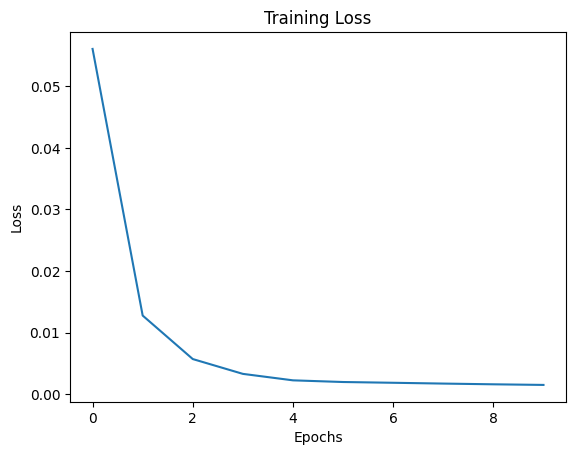

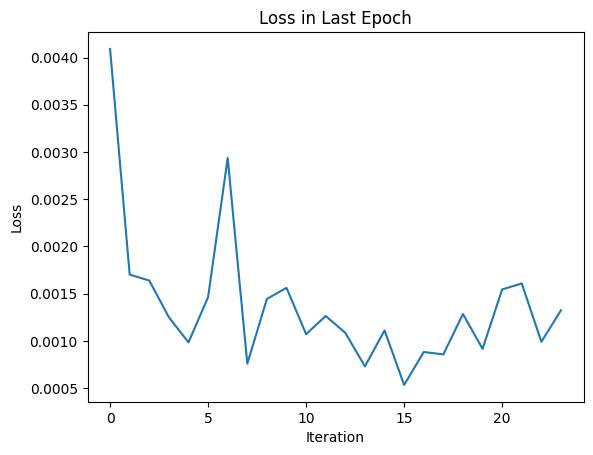

In [10]:
plt.plot([sum(epoch_losses)/len(epoch_losses) for epoch_losses in losses])
# new_epochs = range(0, len(losses), len(losses)//epochs)
# for epoch in new_epochs:
#     plt.axvline(x=epoch, color='r', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(losses[-1][:24])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss in Last Epoch')
plt.show()


In [11]:
from load_data import getTestData
model.load_state_dict(torch.load('lstm_trained_model.pth'))

model.eval()

data = getTestData()

data = (data[0].astype(np.float32), data[1])
def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    X_test = X_test.copy()
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    with torch.no_grad():
        for i in range(forecast_horizon):
            x = torch.tensor(X_test[i:i+forecast_horizon]).to(device)
            x = x.view(1,forecast_horizon,input_size)
            output = model.forward(x,sequence_length=forecast_horizon,input_size=input_size)
            predictions.append(output.item())
            X_test[i+forecast_horizon][-1] = output.item()
    return predictions


preds=predict_one_horizon(model, data[0][:48], 24, 24)

   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998


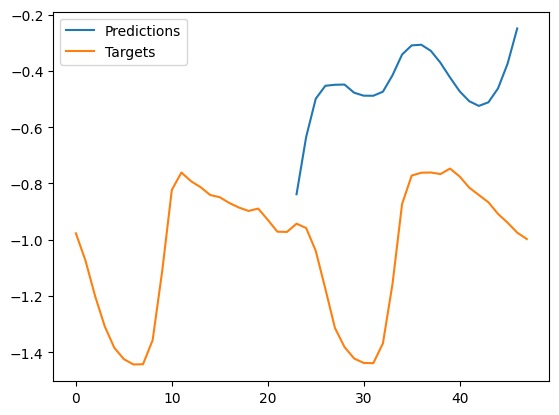

In [12]:
def plot_predictions(predictions, targets):
    
    plt.plot([i for i in range(23,47)], predictions, label='Predictions')
    
    plt.plot(targets[0:48], label='Targets')
    plt.legend()
    plt.show()
    
plot_predictions(preds, data[1])

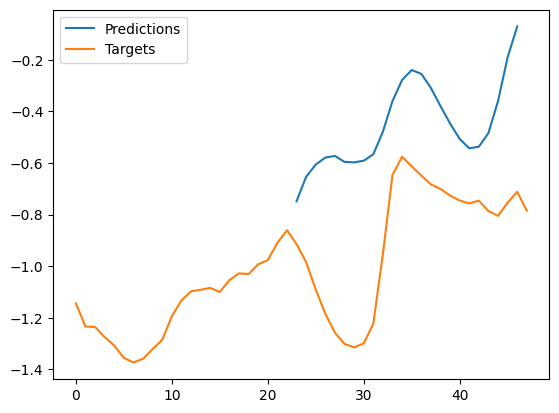

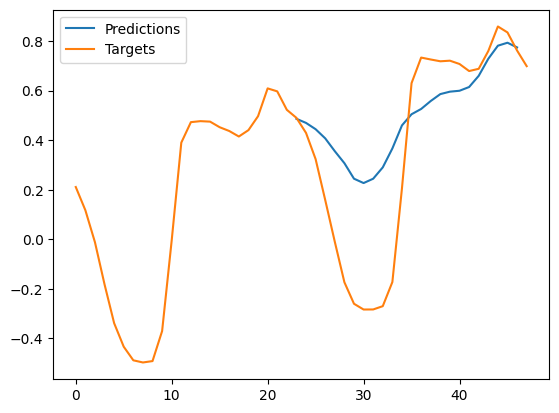

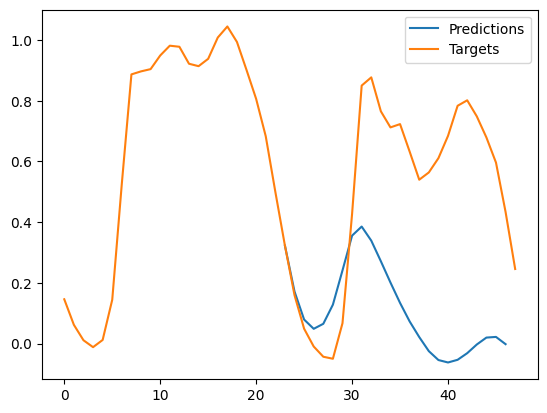

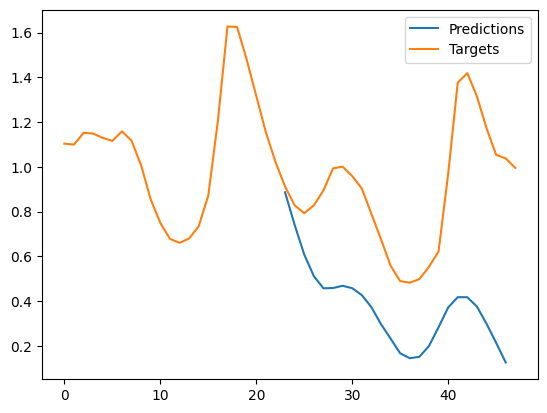

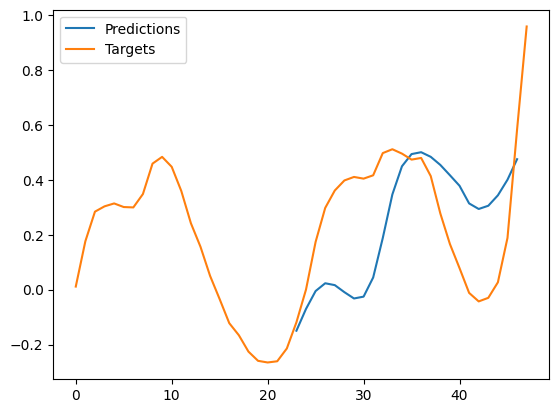

0.24068200727529968


In [13]:
import random
def average_error_over_horizons(model, X_test, y_test, forecast_horizon):
    errors = []
    random.seed(42)
    random_numbers = random.sample(range(len(X_test)-2*forecast_horizon), 5)
    
    for i in range(len(X_test)-2*forecast_horizon):
        preds = predict_one_horizon(model, X_test[i:i+2*forecast_horizon], given_cases=forecast_horizon, forecast_horizon=forecast_horizon)
        error = np.mean(np.square(preds-y_test[i+forecast_horizon-1:i+2*forecast_horizon-1]))
        errors.append(error)
        if i in random_numbers:
            plot_predictions(preds, y_test[i:i+2*forecast_horizon])
    return np.mean(errors)

print(average_error_over_horizons(model, data[0], data[1], 24))